10.00 percent of data analyzed


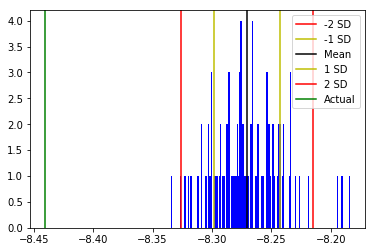

20.00 percent of data analyzed


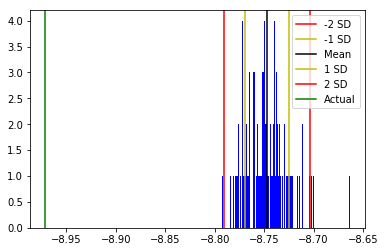

29.99 percent of data analyzed


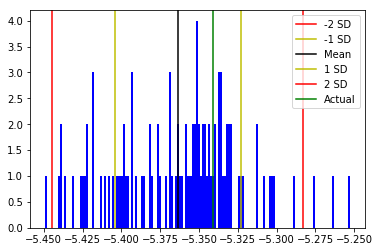

39.99 percent of data analyzed


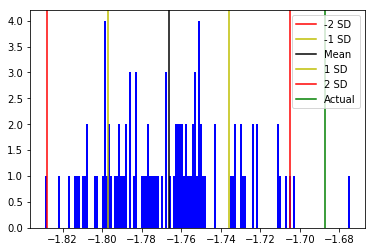

49.99 percent of data analyzed


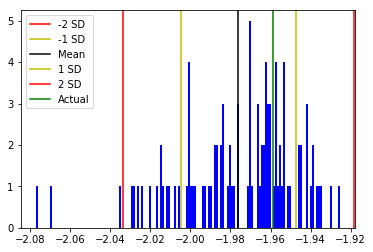

59.99 percent of data analyzed


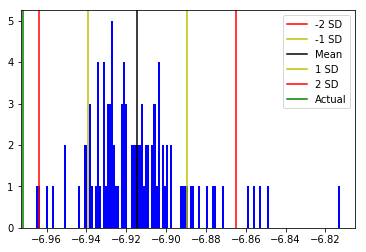

69.99 percent of data analyzed


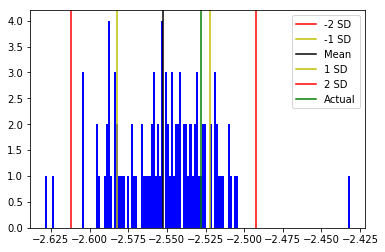

79.98 percent of data analyzed


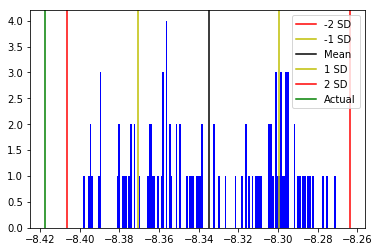

89.98 percent of data analyzed


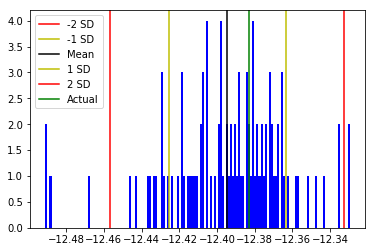

99.98 percent of data analyzed


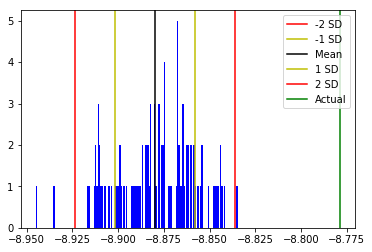

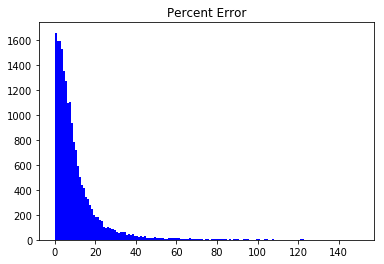

Percent Error Mean: 10.653404204655088
Percent Error Standard Deviation: 19.66060560575393

Number outside of 5 standard deviations: 3201
Number between 4 and 5 standard deviations: 1371
Number between 3 and 4 standard deviations: 2060
Number between 2 and 3 standard deviations: 3131
Number between 1 and 2 standard deviations: 4344
Number inside 1 standard deviation: 5207
Number below distribution minimum: 4343
Number above distribution maximum: 3787

Percent inside 1 standard deviation: 26.959718339028683
Percent inside 2 standard deviations: 49.45117531324428
Percent inside 3 standard deviations: 65.66221393807601
Percent inside 4 standard deviations: 76.32805219012116
Percent inside 5 standard deviations: 83.42652997825411
Percent outside 5 standard deviations: 16.573470021745884
Percent below distribution minimum: 22.486279382831107
Percent above distribution maximum: 19.607538573055816


In [19]:
import pylab as plt
import numpy as np
import os

from scipy import stats

from BNN_functions import normalizeData
%matplotlib inline

trainIn=np.loadtxt("fullTrainInput.txt",delimiter="\t",skiprows=1)
trainOut=np.loadtxt("fullTrainOutput.txt",delimiter="\t",skiprows=1)
valIn=np.loadtxt("fullValidateInput.txt",delimiter="\t",skiprows=0)
valOut=np.loadtxt("fullValidateOutput.txt",delimiter="\t",skiprows=0)

normInfo, data = normalizeData(trainIn, trainOut, valIn, valOut) 

directory=os.getcwd()+"/3Deep50WideReluHMC/"
summary=[]

with open(directory+"summary.txt","r") as file:
    for line in iter(file):
        summary.append(line.split())
numNetworks=int(summary[-1][0])
numMatrices=int(summary[-1][1])
matrices=[]
for n in range(numMatrices):
    weights=np.loadtxt(directory+str(n)+".txt", dtype=np.float32,ndmin=2)
    weightsSplitDims=(numNetworks,int(summary[n][0]),int(summary[n][1]))
    weights0=np.zeros(weightsSplitDims)
    for n in range(numNetworks):
        weights0[n,:,:]=weights[weightsSplitDims[1]*n:weightsSplitDims[1]*(n+1),:weightsSplitDims[2]]
    matrices.append(weights0)

inputVal=np.transpose(data[2])
results=[None]*numNetworks
for m in range(numNetworks):
    current=inputVal
    for n in range(0,numMatrices,2):
        #print(current.shape, matrices[n][m,:,:].shape)
        current=np.matmul(matrices[n][m,:,:],current)
        current+=matrices[n+1][m,:,:]
        if(n+2<numMatrices):
            current=np.maximum(current,0)
    results[m]=current

results=np.array(results)
real=data[3]*normInfo[0][1]+normInfo[0][0]
wrong=[]
sd5=[]
sd4=[]
sd3=[]
sd2=[]
sd1=[]
belMin=[]
abvMax=[]
percentError=[]
results=results*normInfo[0][1]+normInfo[0][0]
decile=int(len(results[0,0,:])/10)
for k in range(len(results[0,0,:])):
    
    #fit output distribution
    minimum=min(results[:,0,k])
    maximum=max(results[:,0,k])
    mean, sd = stats.norm.fit(results[:,0,k])
    
    #calculate the unnormalized values at each of the standard deviations
    low5=mean-sd*5
    low4=mean-sd*4
    low99=mean-sd*3
    low95=mean-sd*2
    low68=mean-sd
    high68=mean+sd
    high95=mean+sd*2
    high99=mean+sd*3
    high4=mean+sd*4
    high5=mean+sd*5
    actual=real[k]
    
    expLow=np.exp(low95)
    expHigh=np.exp(high95)
    expMean=np.exp(mean)
    expActual=np.exp(actual) 
    #write data to the output file

    percentError.append(100*abs(expMean-expActual)/(expActual))
    #percentError.append(100*abs(mean-actual)/(actual))
    
    
    #Compare values to distribution max and min
    if(actual<minimum):
        belMin.append(k)
    elif(actual>maximum):
        abvMax.append(k)    
    
    #Find out where the actual data point falls in the output distribtuion
    if(actual<=low5 or actual>=high5):
        wrong.append(k)
    elif(actual<low4):
        sd5.append(k)
    elif(actual<low99):
        sd4.append(k)
    elif(actual<low95):
        sd3.append(k)
    elif(actual<low68):
        sd2.append(k)
    elif(actual<high68):
        sd1.append(k)
    elif(actual<high95):
        sd2.append(k)
    elif(actual<high99):
        sd3.append(k)
    elif(actual<high4):
        sd4.append(k)
    elif(actual<high5):
        sd5.append(k)
        
    if((k+1)%decile==0):
        print("{:.2f} percent of data analyzed".format(100*(k+1)/len(results[0,0,:])))
        plt.figure(k)
        plt.hist(results[:,0,k],color="b", bins=150)

        plt.axvline(x=low95,color="r")
        plt.axvline(x=low68,color="y")
        plt.axvline(x=mean,color="k")
        plt.axvline(x=high68,color="y")
        plt.axvline(x=high95,color="r")
        plt.axvline(x=actual,color="g")
        plt.legend(["-2 SD", "-1 SD", "Mean", "1 SD", "2 SD", "Actual"])
        plt.show();


mean, sd = stats.norm.fit(percentError)
plt.figure(20)
plt.hist(percentError,color="b", bins=150,range=(0,150))
plt.title("Percent Error")
plt.show()

print("Percent Error Mean:", mean)
print("Percent Error Standard Deviation:", sd)
print()


print("Number outside of 5 standard deviations:", len(wrong))
print("Number between 4 and 5 standard deviations:", len(sd5))
print("Number between 3 and 4 standard deviations:", len(sd4))
print("Number between 2 and 3 standard deviations:", len(sd3))
print("Number between 1 and 2 standard deviations:", len(sd2))
print("Number inside 1 standard deviation:", len(sd1))
print("Number below distribution minimum:", len(belMin))
print("Number above distribution maximum:", len(abvMax))
print()
print("Percent inside 1 standard deviation:", 100*len(sd1)/len(results[0,0,:]))
print("Percent inside 2 standard deviations:",100*(len(sd1)+len(sd2))/len(results[0,0,:]))
print("Percent inside 3 standard deviations:",100*(len(sd1)+len(sd2)+len(sd3))/len(results[0,0,:]))
print("Percent inside 4 standard deviations:",100*(len(sd1)+len(sd2)+len(sd3)+len(sd4))/len(results[0,0,:]))
print("Percent inside 5 standard deviations:",100*(len(sd1)+len(sd2)+len(sd3)+len(sd4)+len(sd5))/len(results[0,0,:]))
print("Percent outside 5 standard deviations:", 100*len(wrong)/len(results[0,0,:]))
print("Percent below distribution minimum:", 100*len(belMin)/len(results[0,0,:]))
print("Percent above distribution maximum:", 100*len(abvMax)/len(results[0,0,:]))
